# Homework 1
*This notebook includes both coding and written questions. Please hand in this notebook file with all the outputs and your answers to the written questions.*

This assignment covers linear filters, convolution and correlation

In [9]:
# Setup
import numpy as np
import matplotlib.pyplot as plt
from time import time
from skimage import io

from __future__ import print_function

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

## Part 1: Convolutions

###1. Implementation 

In this section, you will implement two versions of convolution:
- `conv_nested`
- `conv_fast`

First, run the code cell below to load the image to work with.

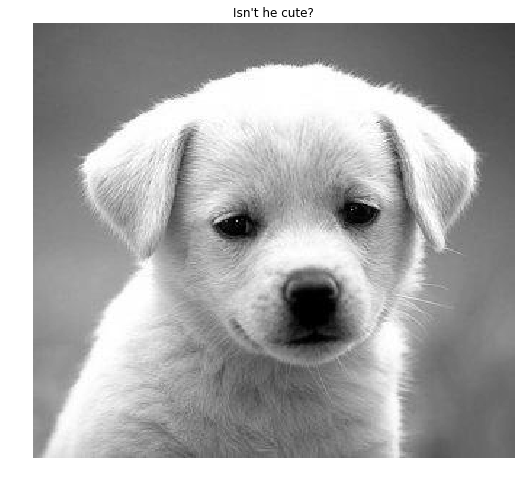

In [10]:
# Open image as grayscale
img = io.imread('data/dog.jpg', as_grey=True)

# Show image
plt.imshow(img)
plt.axis('off')
plt.title("Isn't he cute?")
plt.show()

Now, implement the function **`conv_nested`** in **`filters.py`**. This is a naive implementation of convolution which uses 4 nested for-loops. It takes an image $f$ and a kernel $h$ as inputs and outputs the convolved image $(f*h)$ that has the same shape as the input image. This implementation should take a few seconds to run.

*- Hint: It may be easier to implement $(h*f)$*

We'll first test your `conv_nested` function on a simple input.

In [11]:
def conv_nested(image, kernel):
    """A naive implementation of convolution filter.
    This is a naive implementation of convolution using 4 nested for-loops.
    This function computes convolution of an image with a kernel and outputs
    the result that has the same shape as the input image.
    Args:
        image: numpy array of shape (Hi, Wi)
        kernel: numpy array of shape (Hk, Wk)
    Returns:
        out: numpy array of shape (Hi, Wi)
    """
    ''' 
    for point n,m in image with kernel size 3 we need: 
    image[n-1][m-1] * kernel[0][0] + image[n-1][m] * kernel[0][1] + image[n+1][m+1] * kernel[0][2] etc'...
    '''
    Hi, Wi = image.shape
    Hk, Wk = kernel.shape
    # Get the deltas!
    kernel = np.flip(np.flip(kernel,axis=0),axis=1)
    delta_h = int((Hk-1)/2)
    delta_w = int((Wk-1)/2)
    out = np.zeros((Hi, Wi))
    for image_h in range(1, Hi -delta_h):
        for image_w in range(1, Wi - delta_w):
            sum = 0
            for kernel_h in range(-1*delta_h, delta_h+1):
                for kernel_w in range(-1*delta_w, delta_w+1):
                    sum += (image[image_h + kernel_h][image_w+kernel_w] * kernel[kernel_h+delta_h][kernel_w+delta_w])
            out[image_h][image_w] = sum
    return out

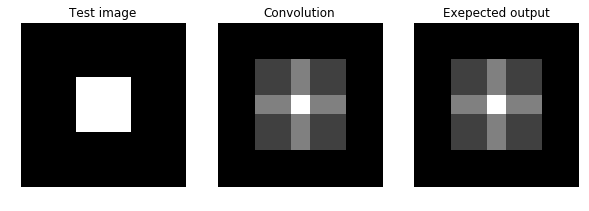

In [12]:
# Simple convolution kernel.
kernel = np.array(
[
    [1,0,1],
    [0,0,0],
    [1,0,1]
])

# Create a test image: a white square in the middle
test_img = np.zeros((9, 9))
test_img[3:6, 3:6] = 1

# Run your conv_nested function on the test image
test_output = conv_nested(test_img, kernel)

# Build the expected output
expected_output = np.zeros((9, 9))
expected_output[2:7, 2:7] = 1
expected_output[4, 2:7] = 2
expected_output[2:7, 4] = 2
expected_output[4, 4] = 4

# Plot the test image
plt.subplot(1,3,1)
plt.imshow(test_img)
plt.title('Test image')
plt.axis('off')

# Plot your convolved image
plt.subplot(1,3,2)
plt.imshow(test_output)
plt.title('Convolution')
plt.axis('off')

# Plot the exepected output
plt.subplot(1,3,3)
plt.imshow(expected_output)
plt.title('Exepected output')
plt.axis('off')
plt.show()

# Test if the output matches expected output
assert np.max(test_output - expected_output) < 1e-10, "Your solution is not correct."

Now let's test your `conv_nested` function on a real image.

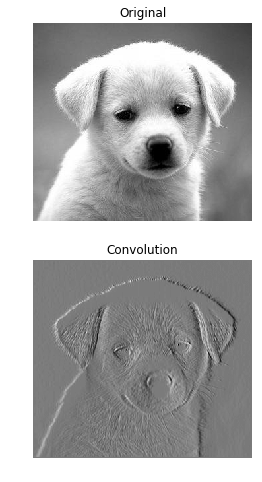

In [13]:
# Simple convolution kernel.
# Feel free to change the kernel and to see different outputs.
kernel = np.array(
[
    [1,0,-1],
    [2,0,-2],
    [1,0,-1]
])

out = conv_nested(img, kernel)

# Plot original image
plt.subplot(2,2,1)
plt.imshow(img)
plt.title('Original')
plt.axis('off')

# Plot your convolved image
plt.subplot(2,2,3)
plt.imshow(out)
plt.title('Convolution')
plt.axis('off')

plt.show()

Let us implement a more efficient version of convolution using array operations in numpy. As shown in the lecture, a convolution can be considered as a sliding window that computes sum of the pixel values weighted by the flipped kernel. The faster version will i) zero-pad an image, ii) flip the kernel horizontally and vertically, and iii) compute weighted sum of the neighborhood at each pixel.

In [14]:
def zero_pad(image, pad_height, pad_width):
    """ Zero-pad an image.
    Ex: a 1x1 image [[1]] with pad_height = 1, pad_width = 2 becomes:
        [[0, 0, 0, 0, 0],
         [0, 0, 1, 0, 0],
         [0, 0, 0, 0, 0]]         of shape (3, 5)
    Args:
        image: numpy array of shape (H, W)
        pad_width: width of the zero padding (left and right padding)
        pad_height: height of the zero padding (bottom and top padding)
    Returns:
        out: numpy array of shape (H+2*pad_height, W+2*pad_width)
    """

    H, W = image.shape
    out = None

    ### YOUR CODE HERE
    out = np.zeros((H+2*pad_height, W+2*pad_width))
    out[pad_height:pad_height+H, pad_width:pad_width+W] = image
    ### END YOUR CODE
    return out

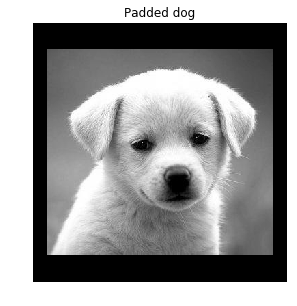

In [15]:
pad_width = 20 # width of the padding on the left and right
pad_height = 40 # height of the padding on the top and bottom

padded_img = zero_pad(img, pad_height, pad_width)

# Plot your padded dog
plt.subplot(1,2,1)
plt.imshow(padded_img)
plt.title('Padded dog')
plt.axis('off')

plt.show()

Next, complete the function **`conv_fast`** using `zero_pad`. Run the code below to compare the outputs by the two implementations. `conv_fast` should run significantly faster than `conv_nested`.  
Depending on your implementation and computer, `conv_nested` should take a few seconds and `conv_fast` should be around 5 times faster.

In [16]:
def conv_fast(image, kernel):
    """ An efficient implementation of convolution filter.
    This function uses element-wise multiplication and np.sum()
    to efficiently compute weighted sum of neighborhood at each
    pixel.
    Hints:
        - Use the zero_pad function you implemented above
        - There should be two nested for-loops
        - You may find np.flip() and np.sum() useful
    Args:
        image: numpy array of shape (Hi, Wi)
        kernel: numpy array of shape (Hk, Wk)
    Returns:
        out: numpy array of shape (Hi, Wi)
    """
    Hi, Wi = image.shape
    out = np.zeros((Hi, Wi))
    ### YOUR CODE HERE

    # Flip the kernel
    kernel = np.flip(np.flip(kernel, axis=0), axis=1)
    Hk, Wk = kernel.shape
    delta_h = int((Hk - 1) / 2)
    delta_w = int((Wk - 1) / 2)
    for image_h in range(delta_h, Hi-delta_h):
        for image_w in range(delta_w, Wi-delta_w):
            out[image_h][image_w] = np.sum(kernel*image[image_h-delta_h:image_h+delta_h+1,image_w-delta_w:image_w+delta_w+1])
    ### END YOUR CODE

    return out

conv_nested: took 0.850558 seconds.
conv_fast: took 0.566927 seconds.


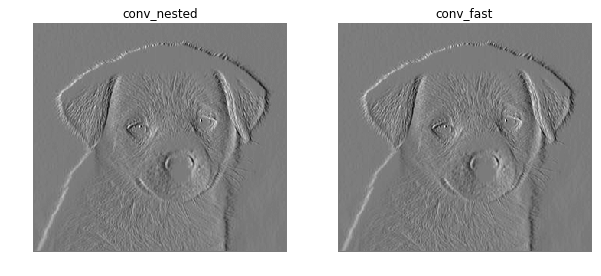

In [17]:
t0 = time()
out_fast = conv_fast(img, kernel)
t1 = time()
out_nested = conv_nested(img, kernel)
t2 = time()

# Compare the running time of the two implementations
print("conv_nested: took %f seconds." % (t2 - t1))
print("conv_fast: took %f seconds." % (t1 - t0))

# Plot conv_nested output
plt.subplot(1,2,1)
plt.imshow(out_nested)
plt.title('conv_nested')
plt.axis('off')

# Plot conv_fast output
plt.subplot(1,2,2)
plt.imshow(out_fast)
plt.title('conv_fast')
plt.axis('off')

# Make sure that the two outputs are the same
if not (np.max(out_fast - out_nested) < 1e-10):
    print("Different outputs! Check your implementation.")

---
## Part 2: Cross-correlation

Cross-correlation of two 2D signals $f$ and $g$ is defined as follows:
$$(f\star{g})[m,n]=\sum_{i=-\infty}^\infty\sum_{j=-\infty}^\infty f[i,j]\cdot g[i-m,j-n]$$

### 2.1 Template Matching with Cross-correlation
Suppose that you are a clerk at a grocery store. One of your responsibilites is to check the shelves periodically and stock them up whenever there are sold-out items. You got tired of this laborious task and decided to build a computer vision system that keeps track of the items on the shelf.

The template of a product (`template.jpg`) and the image of shelf (`shelf.jpg`) is provided. We will use cross-correlation to find the product in the shelf.

*- Hint: you may use the `conv_fast` function you implemented in the previous question.*

In [18]:
def cross_correlation(f, g):
    """ Cross-correlation of f and g
    Hint: use the conv_fast function defined above.
    Args:
        f: numpy array of shape (Hf, Wf)
        g: numpy array of shape (Hg, Wg)
    Returns:
        out: numpy array of shape (Hf, Wf)
    """

    out = None
    ### YOUR CODE HERE
    Hi, Wi = f.shape
    Hk, Wk = g.shape
    out = np.zeros((Hi, Wi))
    padh = Hk // 2
    padw = Wk // 2
    img_pad = zero_pad(f, padh, padw)
    for i in range(Hi):
        for j in range(Wi):
            out[i, j] = (img_pad[i:i+Hk, j:j+Wk] * g).sum()
    ### END YOUR CODE

    return out


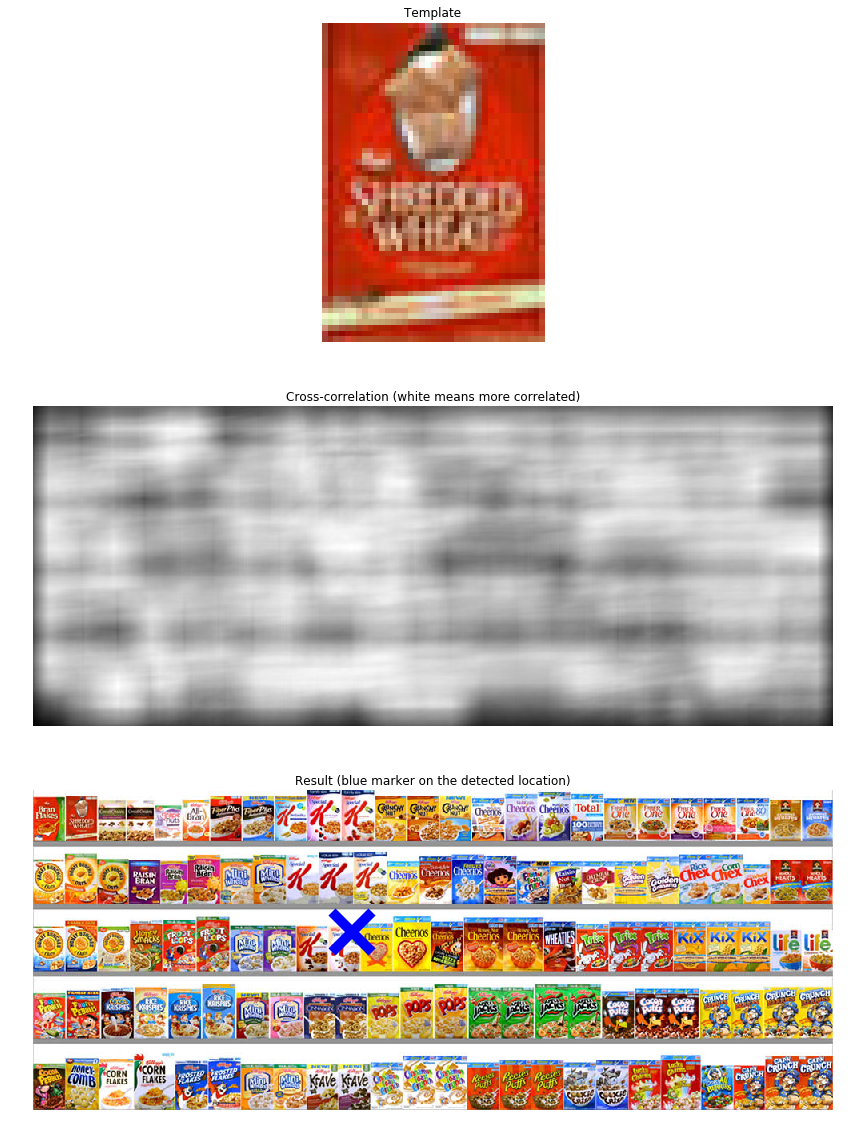

In [19]:
# Load template and image in grayscale
img = io.imread('data/shelf.jpg')
img_grey = io.imread('data/shelf.jpg', as_grey=True)
temp = io.imread('data/template.jpg')
temp_grey = io.imread('data/template.jpg', as_grey=True)

# Perform cross-correlation between the image and the template
out = cross_correlation(img_grey, temp_grey)

# Find the location with maximum similarity
y,x = (np.unravel_index(out.argmax(), out.shape))

# Display product template
plt.figure(figsize=(25,20))
plt.subplot(3, 1, 1)
plt.imshow(temp)
plt.title('Template')
plt.axis('off')

# Display cross-correlation output
plt.subplot(3, 1, 2)
plt.imshow(out)
plt.title('Cross-correlation (white means more correlated)')
plt.axis('off')

# Display image
plt.subplot(3, 1, 3)
plt.imshow(img)
plt.title('Result (blue marker on the detected location)')
plt.axis('off')

# Draw marker at detected location
plt.plot(x, y, 'bx', ms=40, mew=10)
plt.show()


#### Interpretation
How does the output of cross-correlation filter look like? Was it able to detect the product correctly? Explain what might be the problem with using raw template as a filter.

---
### 2.2 Zero-mean cross-correlation
A solution to this problem is to subtract off the mean value of the template so that it has zero mean.

In [20]:
def zero_mean_cross_correlation(f, g):
    """ Zero-mean cross-correlation of f and g
    Subtract the mean of g from g so that its mean becomes zero
    Args:
        f: numpy array of shape (Hf, Wf)
        g: numpy array of shape (Hg, Wg)
    Returns:
        out: numpy array of shape (Hf, Wf)
    """

    out = None
    ### YOUR CODE HERE
    g_mean = np.sum(g)/np.size(g)
    g = g - g_mean
    g = np.flip(np.flip(g, axis=0), axis=1)
    out =  conv_fast(f, g[0:-1])
    ### END YOUR CODE

    return out


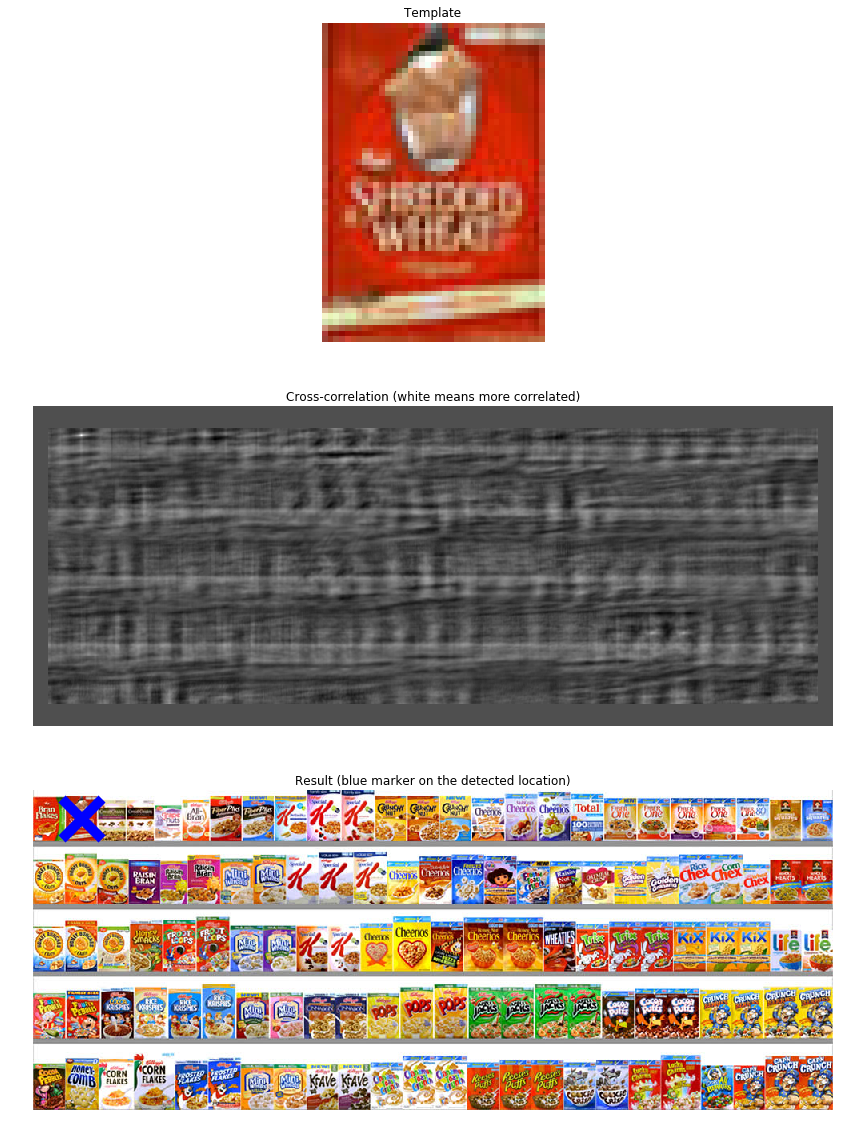

In [21]:
# Perform cross-correlation between the image and the template
out = zero_mean_cross_correlation(img_grey, temp_grey)

# Find the location with maximum similarity
y,x = (np.unravel_index(out.argmax(), out.shape))

# Display product template
plt.figure(figsize=(30,20))
plt.subplot(3, 1, 1)
plt.imshow(temp)
plt.title('Template')
plt.axis('off')

# Display cross-correlation output
plt.subplot(3, 1, 2)
plt.imshow(out)
plt.title('Cross-correlation (white means more correlated)')
plt.axis('off')

# Display image
plt.subplot(3, 1, 3)
plt.imshow(img)
plt.title('Result (blue marker on the detected location)')
plt.axis('off')

# Draw markeimg_greyr at detcted location
plt.plot(x, y, 'bx', ms=40, mew=10)
plt.show()


You can also determine whether the product is present with appropriate scaling and thresholding.

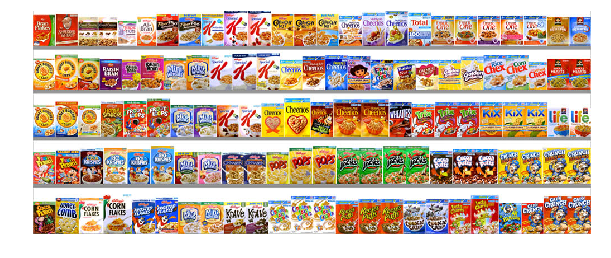

The product is on the shelf


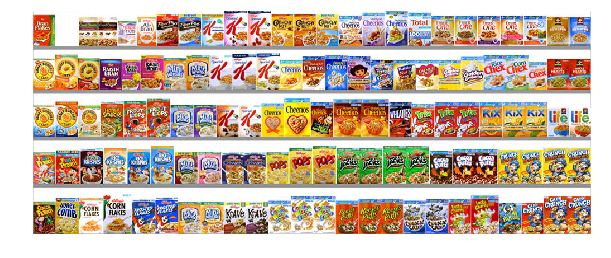

The product is not on the shelf


In [23]:
def check_product_on_shelf(shelf, product):
    out = zero_mean_cross_correlation(shelf, product)
    
    # Scale output by the size of the template
    out = out / float(product.shape[0]*product.shape[1])
    
    # Threshold output (this is arbitrary, you would need to tune the threshold for a real application)
    out = out > 0.025
    
    if np.sum(out) > 0:
        print('The product is on the shelf')
    else:
        print('The product is not on the shelf')

# Load image of the shelf without the product
img2 = io.imread('data/shelf_soldout.jpg')
img2_grey = io.imread('data/shelf_soldout.jpg', as_grey=True)

plt.imshow(img)
plt.axis('off')
plt.show()
check_product_on_shelf(img_grey, temp_grey)

plt.imshow(img2)
plt.axis('off')
plt.show()
check_product_on_shelf(img2_grey, temp_grey)

---
### 2.3 Normalized Cross-correlation (12 points)
One day the light near the shelf goes out and the product tracker starts to malfunction. The `zero_mean_cross_correlation` is not robust to change in lighting condition. The code below demonstrates this.

In [24]:
def normalized_cross_correlation(f, g):
    """ Normalized cross-correlation of f and g
    Normalize the subimage of f and the template g at each step
    before computing the weighted sum of the two.
    Args:
        f: numpy array of shape (Hf, Wf)
        g: numpy array of shape (Hg, Wg)
    Returns:
        out: numpy array of shape (Hf, Wf)
    """

    out = None
    ### YOUR CODE HERE
    g = (g - np.mean(g))/np.std(g)
    f = (f - np.mean(f))/np.std(f)
    Hi, Wi = f.shape
    Hk, Wk = g.shape
    out = np.zeros((Hi, Wi))
    padh = Hk // 2
    padw = Wk // 2
    img_pad = zero_pad(f, padh, padw)
    for i in range(Hi):
        for j in range(Wi):
            img_patch = img_pad[i:i+Hk, j:j+Wk]
            img_normalize = (img_patch - np.mean(img_patch)) / np.std(img_patch)
            out[i, j] = (img_normalize * g).sum()
    ### END YOUR CODE

    return out

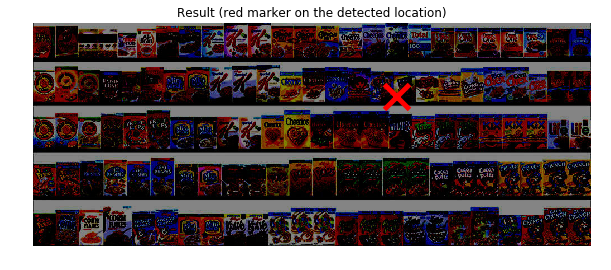

In [28]:
# Load image
img = io.imread('data/shelf_dark.jpg')
img_grey = io.imread('data/shelf_dark.jpg', as_grey=True)

# Perform cross-correlation between the image and the template
out = zero_mean_cross_correlation(img_grey, temp_grey)

# Find the location with maximum similarity
y,x = (np.unravel_index(out.argmax(), out.shape))

# Display image
plt.imshow(img)
plt.title('Result (red marker on the detected location)')
plt.axis('off')

# Draw marker at detcted location
plt.plot(x, y, 'rx', ms=25, mew=5)
plt.show()

A solution is to normalize the pixels of the image and template at every step before comparing them. This is called **normalized cross-correlation**.

The mathematical definition for normalized cross-correlation of $f$ and template $g$ is:
$$(f\star{g})[m,n]=\sum_{i,j} \frac{f[i,j]-\overline{f_{m,n}}}{\sigma_{f_{m,n}}} \cdot \frac{g[i-m,j-n]-\overline{g}}{\sigma_g}$$

where:
- $f_{m,n}$ is the patch image at position $(m,n)$
- $\overline{f_{m,n}}$ is the mean of the patch image $f_{m,n}$
- $\sigma_{f_{m,n}}$ is the standard deviation of the patch image $f_{m,n}$ 
- $\overline{g}$ is the mean of the template $g$
- $\sigma_g$ is the standard deviation of the template $g$

Implement **`normalized_cross_correlation`** function in **`filters.py`** and run the code below.

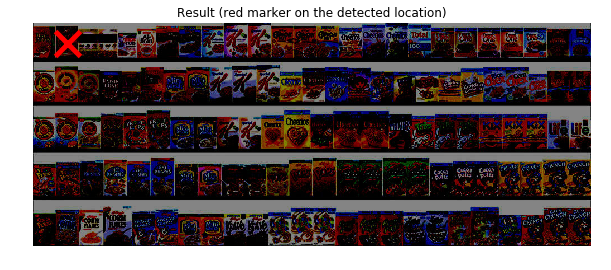

In [29]:
# Perform normalized cross-correlation between the image and the template
out = normalized_cross_correlation(img_grey, temp_grey)

# Find the location with maximum similarity
y,x = (np.unravel_index(out.argmax(), out.shape))

# Display image
plt.imshow(img)
plt.title('Result (red marker on the detected location)')
plt.axis('off')

# Draw marker at detcted location
plt.plot(x, y, 'rx', ms=25, mew=5)
plt.show()

## Part 3: Separable Filters

### 3.1 Theory (10 points)
Consider a $M_1\times{N_1}$ image $I$ and a $M_2\times{N_2}$ filter $F$. A filter $F$ is **separable** if it can be written as a product of two 1D filters: $F=F_1F_2$.

For example,
$$F=
\begin{bmatrix}
1 & -1 \\
1 & -1
\end{bmatrix}
$$
can be written as a matrix product of
$$F_1=
\begin{bmatrix}
1  \\
1
\end{bmatrix},
F_2=
\begin{bmatrix}
1 & -1
\end{bmatrix}
$$
Therefore $F$ is a separable filter.

Prove that for any separable filter $F=F_1F_2$,
$$I*F=(I*F_1)*F_2$$

**Your Answer:** *Write your solution in this markdown cell. Please write your equations in [LaTex equations](http://jupyter-notebook.readthedocs.io/en/latest/examples/Notebook/Typesetting%20Equations.html).*

### 3.2 Complexity comparison (10 points)
(i) How many multiplications do you need to do a direct 2D convolution (i.e. $I*F$?)<br>
(ii) How many multiplications do you need to do 1D convolutions on rows and columns (i.e. $(I*F_1)*F_2$)<br>
(iii) Use Big-O notation to argue which one is more efficient in general: direct 2D convolution or two successive 1D convolutions?

**Your Answer:** *Write your solution in this markdown cell. Please write your equations in [LaTex equations](http://jupyter-notebook.readthedocs.io/en/latest/examples/Notebook/Typesetting%20Equations.html).*

Now, we will empirically compare the running time of a separable 2D convolution and its equivalent two 1D convolutions. Gaussian kernel, widely used for blurring images, is one example of a separable filter. Run the code below to see its effect.

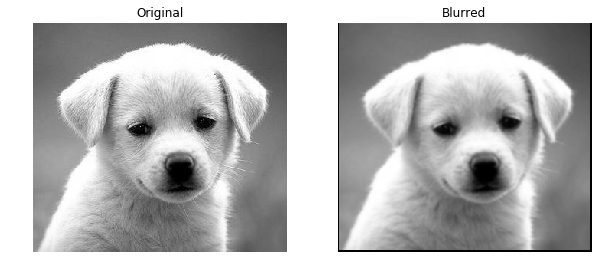

In [30]:
# Load image
img = io.imread('data/dog.jpg', as_grey=True)

# 5x5 Gaussian blur
kernel = np.array(
[
    [1,4,6,4,1],
    [4,16,24,16,4],
    [6,24,36,24,6],
    [4,16,24,16,4],
    [1,4,6,4,1]
])

t0 = time()
out = conv_nested(img, kernel)
t1 = time()
t_normal = t1 - t0

# Plot original image
plt.subplot(1,2,1)
plt.imshow(img)
plt.title('Original')
plt.axis('off')

# Plot convolved image
plt.subplot(1,2,2)
plt.imshow(out)
plt.title('Blurred')
plt.axis('off')

plt.show()

In the below code cell, define the two 1D arrays (`k1` and `k2`) whose product is equal to the Gaussian kernel.

In [33]:
# The kernel can be written as outer product of two 1D filters
k1 = None  # shape (5, 1)
k2 = None  # shape (1, 5)

# ### YOUR CODE HERE
# k1 = np.array([1,4,6,4,1]).reshape((5,1))
# k2 = np.array([1,4,6,4,1]).reshape((1,5))
# ### END YOUR CODE
### YOUR CODE HERE
k1 = np.array([[1], [4], [6], [4], [1]]) 
k2 = np.array([[1,4,6,4,1]])  
### END YOUR CODE

# Check if kernel is product of k1 and k2
if not  np.all(k1 * k2 == kernel):
    print('k1 * k2 is not equal to kernel')
    
assert k1.shape == (5, 1), "k1 should have shape (5, 1)"
assert k2.shape == (1, 5), "k2 should have shape (1, 5)"

We now apply the two versions of convolution to the same image, and compare their running time. Note that the outputs of the two convolutions must be the same.

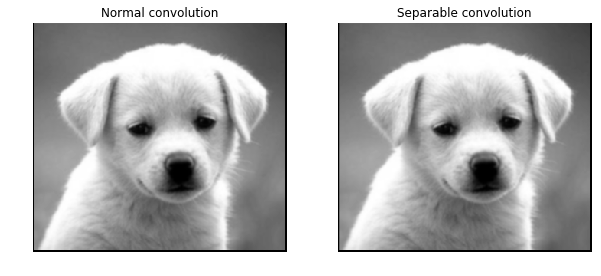

Normal convolution: took 2.221306 seconds.
Separable convolution: took 1.152148 seconds.


In [34]:
# Perform two convolutions using k1 and k2
t0 = time()
out_separable = conv_nested(img, k1)
out_separable = conv_nested(out_separable, k2)
t1 = time()
t_separable = t1 - t0

# Plot normal convolution image
plt.subplot(1,2,1)
plt.imshow(out)
plt.title('Normal convolution')
plt.axis('off')

# Plot separable convolution image
plt.subplot(1,2,2)
plt.imshow(out_separable)
plt.title('Separable convolution')
plt.axis('off')

plt.show()

print("Normal convolution: took %f seconds." % (t_normal))
print("Separable convolution: took %f seconds." % (t_separable))

In [35]:
# Check if the two outputs are equal
assert np.max(out_separable - out) < 1e-10